# Lacmus crop lassifyer

Идея
- сжать изобрадения в 2 раза
- порезать сжатый датасет на кропы размера 224*224 случайным образом
- разделить их на 2 класса - Background и Pedestrian
- сделать аугументацию изображениям
- обучить бинарный классификатор на такой выборке
- попробовать cutmix и др подходы
- сравнить разные имплентации resnet50 и др архитектур

### Шаг 1. Подготовка и анализ данных

**Загрузка LADD**

In [7]:
#import library
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tqdm
%matplotlib inline

In [8]:
# crop data and devide it for 2 folders 
from data_utils.crop import DatasetGridCropper, ImageGridCropper
from data_utils.dataset import LaddDataset

LADD_PATH = '/home/gosha20777/files/datasets/LADD_V4_winter/LizaAlertDroneDatasetV4_Winter/'
LADD_CROP_BASE_PATH = '/home/gosha20777/files/datasets/ladd_crop/base'

if not os.path.isdir(LADD_CROP_BASE_PATH):
    os.mkdir(LADD_CROP_BASE_PATH)

cropper = DatasetGridCropper(
        source_dataset=LaddDataset(path=LADD_PATH),
        target_dataset=LaddDataset(path=LADD_CROP_BASE_PATH),
        image_cropper=ImageGridCropper(
            window_w=224,
            window_h=224,
            overlap_w=112,
            overlap_h=112,
            min_cropped_bbox_square=0.8
        ),
        iter_callback=tqdm.tqdm
    )

cropper.generate_dataset()

0%|          | 0/411 [00:00<?, ?it/s]Reading source dataset...
Generate fragments...
100%|██████████| 411/411 [00:12<00:00, 34.07it/s]
Filter pedestrian fragments...
100%|██████████| 3397/3397 [01:45<00:00, 32.34it/s]
Filter background fragments...
Saving background fragments...
 15%|█▍        | 37152/255656 [21:11<2:09:32, 28.11it/s]

KeyboardInterrupt: 

In [5]:
# augument data
import cv2
from pathlib import Path
import xml.etree.ElementTree as ET 
import numpy as np
import os
import random
from scipy import ndimage
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (1, 1.2), "y": (1, 1.2)}
    )
], random_order=True) # apply augmenters in random order


def transform_target_image(img, p_width, inpaint_width):
    ''' Create boolean and gradient masks for an image, then apply random transformation both for image and masks.
    Returns transformed image ind its masks.'''
    
    inpaint_width = random.randint(inpaint_width-15, inpaint_width+15)

    img_h, img_w, _ = img.shape
 
    # boolean mask of (target size)+(border size) for inpainting
    boolean_mask = np.zeros_like(img).astype('uint8')
    boolean_mask[inpaint_width:img_h-inpaint_width, inpaint_width:img_w-inpaint_width, :]=255
    
    # boolean mask of (target size) for bbox generation
    frame_h = int(np.ceil((img_h-2*inpaint_width)/(1+2*p_width)))
    frame_w = int(np.ceil((img_w-2*inpaint_width)/(1+2*p_width)))
    
    dh = int((img_h-frame_h)/2)
    dw = int((img_w-frame_w)/2)
    
    target_frame = np.zeros_like(img).astype('uint8')
    target_frame[dh:img_h-dh, dw:img_w-dw, :]=255
    
    # gradient mask for simple image mixing
    gradient_mask = np.ones_like(img).astype('float')
    
    for h in range(inpaint_width):
        for w in range(img_w):
            gradient_mask[h, w, :] = h/inpaint_width

    for h in range(img_h-inpaint_width, img_h):
        for w in range(img_w):
            gradient_mask[h, w, :] = (img_h-h)/inpaint_width
            
    for h in range(img_h):
        for w in range(inpaint_width):
            if h<inpaint_width or h>img_h-inpaint_width:               
                gradient_mask[h, w, :] = min(gradient_mask[h, w, 0], w/inpaint_width)
            else:            
                gradient_mask[h, w, :] = w/inpaint_width 
            
    for h in range(img_h):
        for w in range(img_w-inpaint_width, img_w):
            if h<inpaint_width or h>img_h-inpaint_width:
                gradient_mask[h, w, :] = min(gradient_mask[h, w, 0], (img_w-w)/inpaint_width)
            else:            
                gradient_mask[h, w, :] = (img_w-w)/inpaint_width  



    # random rotation   
    #angle = random.random()*360    
    #res_img = ndimage.rotate(img, angle)
    #boolean_mask = ndimage.rotate(boolean_mask, angle)
    #gradient_mask = ndimage.rotate(gradient_mask, angle)
    #target_frame = ndimage.rotate(target_frame, angle)

    imglist = []
    imglist.append(img)
    images_aug = seq.augment_images(imglist)
    img = images_aug[0]
        
    return img, boolean_mask, gradient_mask, target_frame



def place_img_to_background(img, back, b_mask, grad_mask, t_frame):
    ''' Place target image on background, then generate bbox corners'''
    
    # get background size    
    height = back.shape[0]
    width = back.shape[1]
    
    # get insertion point
    h0 = int(random.random()*(height-img.shape[0]))
    w0 = int(random.random()*(width-img.shape[1]))
    
    # extend target img to background size    
    targ = np.zeros_like(back)
    targ[h0:h0+img.shape[0], w0:w0+img.shape[1], :] = img

    # extend target grad_mask to background size
    g_mask = np.zeros_like(back).astype('float')
    g_mask[h0:h0+img.shape[0], w0:w0+img.shape[1], :] = grad_mask
    
    # mix images
    res_img = (targ*g_mask + back*(1-g_mask)).astype('uint8')
    
    # generate bbox
    bbox={}
    bbox['xmin'] = np.min(np.argwhere(np.sum(t_frame[:,:,0], axis=0))) + w0
    bbox['xmax'] = np.max(np.argwhere(np.sum(t_frame[:,:,0], axis=0))) + w0
    bbox['ymin'] = np.min(np.argwhere(np.sum(t_frame[:,:,0], axis=1))) + h0
    bbox['ymax'] = np.max(np.argwhere(np.sum(t_frame[:,:,0], axis=1))) + h0
        
    return res_img, bbox



def draw_bbox(image, bbox):
    '''Draws bbox on image, inputs: image and bbox as a dict'''
    
    image_h, image_w, _ = image.shape

    xmin = bbox['xmin']
    ymin = bbox['ymin']
    xmax = bbox['xmax']
    ymax = bbox['ymax']

    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        
    return image  

class DatasetAug:
    """Формирование нового датасета, разрезая изображения из старого"""

    # noinspection Mypy
    def __init__(self,
                 source_dataset: str,
                 target_folder: str,
                 background_folder: str,
                 p_width: int,
                 inpaint_width: int):
        self.source_dataset = source_dataset
        self.target_folder = target_folder
        self.background_folder = background_folder
        self.p_width = p_width
        self.inpaint_width = inpaint_width
    

    def generate(self):
        # open CFG file, define paths and crops shapes
        dataset_path = self.source_dataset
        backs_folder = self.background_folder
        aug_folder = self.target_folder
        p_width = float(self.p_width) / 100
        inpaint_width = self.inpaint_width

        images_folder      =         'JPEGImages'
        annotations_folder =         'Annotations'

        # Create folders for outputs    
        if not os.path.isdir(aug_folder):
            os.mkdir(aug_folder)
            os.mkdir(Path(aug_folder, 'Targets'))
            os.mkdir(Path(aug_folder, 'Pedestrian'))


        # parse each annotation file
        # cut targets of size: (bbox shape) + (padding width) + (inpaint pixels)
        # save crops in targ_folder

        print('Cropping targets...')

        n_files = len(os.listdir(Path(dataset_path, annotations_folder)))
        passed_files=1

        for filename in os.listdir(Path(dataset_path, annotations_folder)):

            if not filename.endswith('.xml'): continue

            fullname = Path(dataset_path, annotations_folder, filename)    
            tree = ET.parse(fullname)    
            root = tree.getroot()    
            bbox_num = 0
            img = cv2.imread(str(Path(dataset_path, images_folder, filename[:-3]+'jpg')))

            for rec in root:

                # get source image size
                if rec.tag == 'size': 
                    height = int(rec.findtext('height'))
                    width = int(rec.findtext('width'))

                # list all available bboxes        
                if rec.tag == 'object': 
                    for box in rec:
                        if box.tag=='bndbox':

                            # get bbox corners
                            ymin = int(box.findtext('ymin'))
                            ymax = int(box.findtext('ymax'))
                            xmin = int(box.findtext('xmin'))
                            xmax = int(box.findtext('xmax'))

                            if (xmax-xmin)>(ymax-ymin):
                                frame_px = int((xmax-xmin)*p_width)
                            else:
                                frame_px = int((ymax-ymin)*p_width)

                            new_xmin = xmin - frame_px - inpaint_width
                            new_xmax = xmax + frame_px + inpaint_width
                            new_ymin = ymin - frame_px - inpaint_width
                            new_ymax = ymax + frame_px + inpaint_width

                            # do not proceed if target+frame are outside of image
                            if (new_xmin<1 or new_xmax>width-1 or new_ymin<1 or new_ymax>height-1):continue

                            # cut&save target
                            targ = img[new_ymin:new_ymax, new_xmin:new_xmax]
                            cv2.imwrite(str(Path(aug_folder, 'Targets', filename[:-4]+'_'+str(bbox_num)+'_target.jpg')), targ)

                            # goto next bbox in current file
                            bbox_num = bbox_num + 1

            if passed_files in np.int8(np.linspace(0,n_files,10)): print(str(int(passed_files/n_files*10*10))+'% done...')
            passed_files+=1

        print('Crop completed.')

        # transform cropped targets, then place them on backgrounds

        n_files = len(os.listdir(backs_folder))*len(os.listdir(Path(aug_folder, 'Targets')))
        passed_files=1

        print('Starting augmentation...')

        for background_file in os.listdir(backs_folder):
            if random.randint(0, 100) < 65:
                continue 

            back = cv2.imread(str(Path(backs_folder, background_file)))

            for target_file in os.listdir(Path(aug_folder, 'Targets')):
                
                if random.randint(0, 100) < 60:
                    continue   

                targ = cv2.imread(str(Path(aug_folder, 'Targets', target_file)))        

                # transform target image
                targ, b_mask, g_mask, t_frame = transform_target_image(targ, p_width, inpaint_width)

                # place transformed target image on background image
                try:
                    res_img, bbox = place_img_to_background(targ, back, b_mask, g_mask, t_frame)
                except:
                    continue

                # uncomment line below if need to draw bboxes on images
                # res_img = draw_bbox(res_img, bbox)

                # save files
                cv2.imwrite(str(Path(aug_folder, 'Pedestrian', target_file[:-4]+'_on_'+ background_file[:-4]+'.png')), res_img)

                if passed_files in np.int8(np.linspace(0,n_files,10)): print(str(int(passed_files/n_files*10*10))+'% done...')
                passed_files+=1

        print('All images are processed.')


img_aug = DatasetAug(
    source_dataset="/home/gosha20777/files/datasets/LADD_V4_winter/LizaAlertDroneDatasetV4_Winter/",
    target_folder="/home/gosha20777/files/datasets/ladd_crop/aug",
    background_folder="/home/gosha20777/files/datasets/ladd_crop/base/Background",
    p_width=25,
    inpaint_width=50)

img_aug.generate()

Cropping targets...
4% done...
10% done...
15% done...
22% done...
26% done...
Crop completed.
Starting augmentation...
0% done...
0% done...
0% done...
0% done...
0% done...


KeyboardInterrupt: 

In [24]:
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/base/*/*') 

# get file pathes
pedestrian_files = [fn for fn in files if 'Pedestrian' in fn] 
background_files = [fn for fn in files if 'Background' in fn]

pedestrian_size = len(pedestrian_files)
background_size = len(background_files)

pedestrian_train_size = int(pedestrian_size * 0.7)
background_train_size = int(background_size * 0.7)

pedestrian_val_size = int(pedestrian_size * 0.2)
background_val_size = int(background_size * 0.2)
# and 10% for test

print(f'total size:\n\tPedestrians: {pedestrian_size}\n\tBackrgound: {background_size}')

# prepare train set (70%)
pedestrian_train = list(np.random.choice(pedestrian_files, size=pedestrian_train_size, replace=False))
background_train = list(np.random.choice(background_files, size=background_train_size, replace=False))

# prepare val set
pedestrian_files = list(set(pedestrian_files) - set(pedestrian_train)) 
background_files = list(set(background_files) - set(background_train)) 

pedestrian_val = list(np.random.choice(pedestrian_files, size=pedestrian_val_size, replace=False))
background_val = list(np.random.choice(background_files, size=background_val_size, replace=False))

# prepare test set
pedestrian_test = list(set(pedestrian_files) - set(pedestrian_val)) 
background_test = list(set(background_files) - set(background_val))
 
print('dataset size:\nlabel\t\ttrain\tval\ttest') 
print(f'Pedestrean\t{len(pedestrian_train)}\t{len(pedestrian_val)}\t{len(pedestrian_test)}')
print(f'Background\t{len(background_train)}\t{len(background_val)}\t{len(background_test)}')

total size:
	Pedestrians: 3397
	Backrgound: 37148
dataset size:
label		train	val	test
Pedestrean	2377	679	341
Background	26003	7429	3716


In [25]:
# copy ciles in ds folder

# winhout aug
base_dir = '/home/gosha20777/files/datasets/ladd_crop'
clean_ds_dir = '/home/gosha20777/files/datasets/ladd_crop/ds_clean'
aug_ds_dir = '/home/gosha20777/files/datasets/ladd_crop/ds_aug'

if not os.path.isdir(clean_ds_dir):
    os.mkdir(clean_ds_dir)
    os.mkdir(os.path.join(clean_ds_dir, "train"))
    os.mkdir(os.path.join(clean_ds_dir, "test"))
    os.mkdir(os.path.join(clean_ds_dir, "val"))
    os.mkdir(os.path.join(clean_ds_dir, "train", "Pedestrian"))
    os.mkdir(os.path.join(clean_ds_dir, "train", "Background"))
    os.mkdir(os.path.join(clean_ds_dir, "test", "Pedestrian"))
    os.mkdir(os.path.join(clean_ds_dir, "test", "Background"))
    os.mkdir(os.path.join(clean_ds_dir, "val", "Pedestrian"))
    os.mkdir(os.path.join(clean_ds_dir, "val", "Background"))

if not os.path.isdir(aug_ds_dir):
    os.mkdir(aug_ds_dir)
    os.mkdir(os.path.join(aug_ds_dir, "train"))
    os.mkdir(os.path.join(aug_ds_dir, "test"))
    os.mkdir(os.path.join(aug_ds_dir, "val"))
    os.mkdir(os.path.join(aug_ds_dir, "train", "Pedestrian"))
    os.mkdir(os.path.join(aug_ds_dir, "train", "Background"))
    os.mkdir(os.path.join(aug_ds_dir, "test", "Pedestrian"))
    os.mkdir(os.path.join(aug_ds_dir, "test", "Background"))
    os.mkdir(os.path.join(aug_ds_dir, "val", "Pedestrian"))
    os.mkdir(os.path.join(aug_ds_dir, "val", "Background"))

# copy files in clean dir
for f in pedestrian_train:
    shutil.copyfile(f, os.path.join(clean_ds_dir, "train", "Pedestrian", os.path.basename(f)))
for f in pedestrian_test:
    shutil.copyfile(f, os.path.join(clean_ds_dir, "test", "Pedestrian", os.path.basename(f)))
for f in pedestrian_val:
    shutil.copyfile(f, os.path.join(clean_ds_dir, "val", "Pedestrian", os.path.basename(f)))

for f in background_train:
    shutil.copyfile(f, os.path.join(clean_ds_dir, "train", "Background", os.path.basename(f)))
for f in background_test:
    shutil.copyfile(f, os.path.join(clean_ds_dir, "test", "Background", os.path.basename(f)))
for f in background_val:
    shutil.copyfile(f, os.path.join(clean_ds_dir, "val", "Background", os.path.basename(f)))

# copy files in aug dir

pedestrian_aug_train = glob.glob('/home/gosha20777/files/datasets/ladd_crop/aug/Pedestrian/*')
pedestrian_aug_train = list(np.random.choice(pedestrian_aug_train, size=background_train_size, replace=False))

for f in pedestrian_aug_train:
    shutil.copyfile(f, os.path.join(aug_ds_dir, "train", "Pedestrian", os.path.basename(f)))
for f in pedestrian_test:
    shutil.copyfile(f, os.path.join(aug_ds_dir, "test", "Pedestrian", os.path.basename(f)))
for f in pedestrian_val:
    shutil.copyfile(f, os.path.join(aug_ds_dir, "val", "Pedestrian", os.path.basename(f)))

for f in background_train:
    shutil.copyfile(f, os.path.join(aug_ds_dir, "train", "Background", os.path.basename(f)))
for f in background_test:
    shutil.copyfile(f, os.path.join(aug_ds_dir, "test", "Background", os.path.basename(f)))
for f in background_val:
    shutil.copyfile(f, os.path.join(aug_ds_dir, "val", "Background", os.path.basename(f)))

print('done')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_clean/train/Pedestrian/*')
print(f'clean train Pedestrian {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_clean/val/Pedestrian/*')
print(f'clean val Pedestrian {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_clean/test/Pedestrian/*')
print(f'clean teat Pedestrian {len(files)}')

files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_clean/train/Background/*')
print(f'clean train Background {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_clean/val/Background/*')
print(f'clean val Background {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_clean/test/Background/*')
print(f'clean teat Background {len(files)}')

files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_aug/train/Pedestrian/*')
print(f'aug train Pedestrian {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_aug/val/Pedestrian/*')
print(f'aug val Pedestrian {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_aug/test/Pedestrian/*')
print(f'aug teat Pedestrian {len(files)}')

files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_aug/train/Background/*')
print(f'aug train Background {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_aug/val/Background/*')
print(f'aug val Background {len(files)}')
files = glob.glob('/home/gosha20777/files/datasets/ladd_crop/ds_aug/test/Background/*')
print(f'aug teat Background {len(files)}')

done
clean train Pedestrian 2377
clean val Pedestrian 679
clean teat Pedestrian 341
clean train Background 26003
clean val Background 7429
clean teat Background 3716
aug train Pedestrian 26003
aug val Pedestrian 679
aug teat Pedestrian 341
aug train Background 26003
aug val Background 7429
aug teat Background 3716


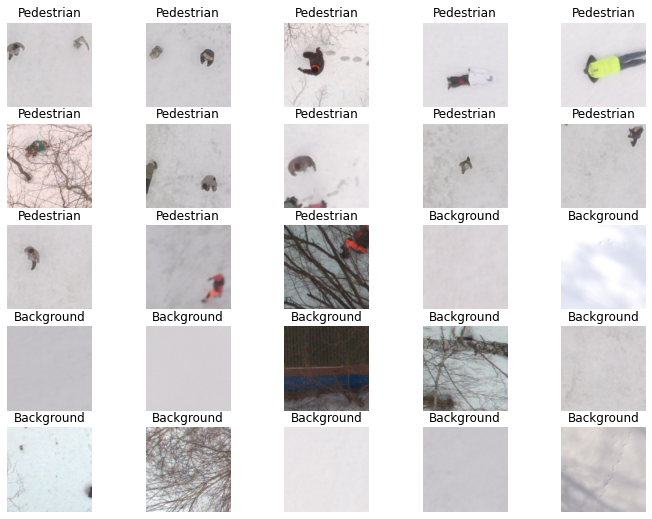

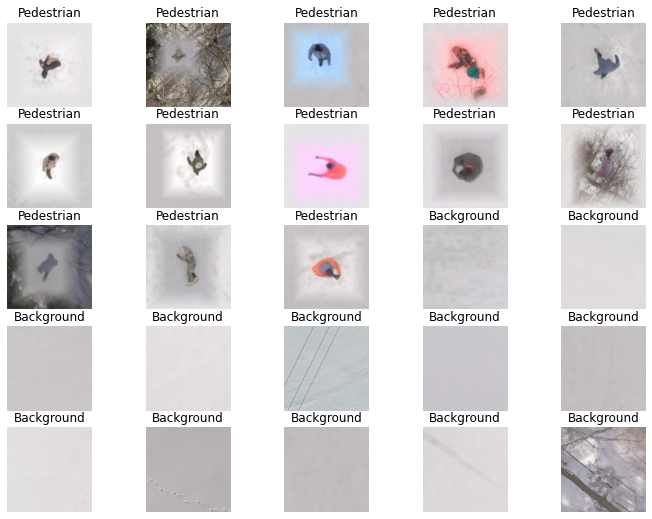

In [27]:
# visualize data
from PIL import Image

pedestrian = np.random.choice(pedestrian_train, 13)
background = np.random.choice(background_train, 12)
data = np.concatenate((pedestrian, background))
labels = 13 * ['Pedestrian'] + 12 *['Background']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

pedestrian = np.random.choice(pedestrian_aug_train, 13)
background = np.random.choice(background_train, 12)
data = np.concatenate((pedestrian, background))
labels = 13 * ['Pedestrian'] + 12 *['Background']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

In [52]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from data_utils.ImageDataAugmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
import tqdm

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

TRAIN_DIR = '/home/gosha20777/files/datasets/ladd_crop/ds_aug/train'
VAL_DIR = '/home/gosha20777/files/datasets/ladd_crop/ds_aug/val'
TEST_DIR = '/home/gosha20777/files/datasets/ladd_crop/ds_aug/test'
WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32
   
TRAIN_AUGMENTATIONS = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=0.5)

train_datagen = ImageDataAugmentor(
    preprocess_input=preprocess_input,
    augment=TRAIN_AUGMENTATIONS)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH), batch_size=BATCH_SIZE, class_mode='binary')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 52006 images belonging to 2 classes.
Found 8108 images belonging to 2 classes.


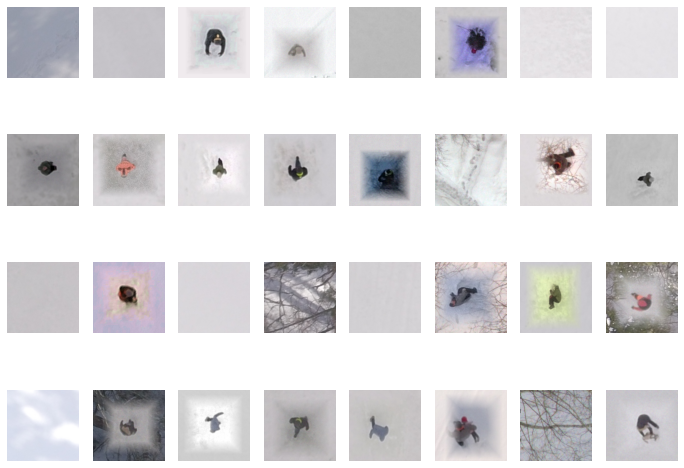

In [53]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

### Шаг 2. Обучение моделей
#### Resnt50v2 (Keras)

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Model

WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 32

restnet50 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(HEIGHT,WIDTH,3))

output = restnet50.layers[-1].output
output = tf.keras.layers.Flatten()(output)
restnet50 = Model(restnet50.input, output)

for layer in restnet50.layers:
    layer.trainable = False

restnet50.summary()

1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block1_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_out (Add)          (None, 14, 14, 1024) 0           conv4_block1_0_conv[0][0]        
                                                                 conv4_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_preact_bn (BatchNo (None, 14, 14, 1024) 4096        conv4_block1_out[0][0]           
__________________________________________________________________________________________________
conv4_block2_preact_relu (Activ (None, 14, 14, 1024) 0           conv4_block2_preact_bn[0][0]     
______________________________________________________________________________________

In [55]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet50)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='softplus'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 100352)            23564800  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 75,208,705
Trainable params: 51,643,905
Non-trainable params: 23,564,800
_________________________________

In [56]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=100,
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              verbose=1)

Epoch 1/100
 15/100 [===>..........................] - ETA: 1:43 - loss: 2.1961 - accuracy: 0.8354

KeyboardInterrupt: 

#### Resnet34 (Keras)

In [ ]:
# pyhon code here

### Resnet50 (https://github.com/qubvel/classification_models)

In [ ]:
# pyhon code here